In [1]:
def parse_df_to_res(df):
    """
    解析DataFrame，将列数据重新组织为嵌套字典结构
    
    Args:
        df: DataFrame，列名格式如 X16, X15, X14, ..., X10, X1(y) 或 X6, X5, ..., X0, X(y)
    
    Returns:
        dict: {方程: {阶数/变量: 值}}
    """
    res = {}
    
    for row_idx, row in df.iterrows():
        for col in df.columns:
            # 解析列名
            if '(' in col and ')' in col:
                # 处理带括号的列，如 X1(y), X2(y), Y1(x), X(y), Y(x)
                equation_part = col.split('(')[0]  # X1, X2, Y1, X, Y等
                variable = col.split('(')[1].rstrip(')')  # y, x等
                
                # 如果没有数字，默认为1
                if equation_part in ['X', 'Y']:
                    equation = equation_part + '1'  # X -> X1, Y -> Y1
                else:
                    equation = equation_part
                
                if equation not in res:
                    res[equation] = {}
                res[equation][variable] = row[col]
                
            else:
                # 处理不带括号的列，如 X16, X15, Y16, X6, X5, X36, X46等
                if col[0] in ['X', 'Y']:
                    equation_prefix = col[0]  # X 或 Y
                    order = col[1:]  # 16, 15, 14, 6, 5, 36, 46等
                    
                    # 动态判断方程编号和阶数
                    if len(order) >= 2:
                        # 多位数的情况
                        first_digit = int(order[0])  # 第一位数字
                        remaining = order[1:]        # 剩余部分
                        
                        if first_digit >= 1:
                            # 第一位数字就是方程编号
                            equation = equation_prefix + str(first_digit)
                            actual_order = remaining
                        else:
                            # 默认为1号方程
                            equation = equation_prefix + '1'
                            actual_order = order
                    else:
                        # 单位数的情况，默认为1号方程
                        equation = equation_prefix + '1'
                        actual_order = order
                    
                    if equation not in res:
                        res[equation] = {}
                    res[equation][actual_order] = row[col]
    return res

def print_result(result):
    """
    格式化打印结果，每个方程分行显示
    """
    print("解析结果：")
    print("=" * 50)
    
    for equation, data in result.items():
        print(f"\n方程 {equation}:")
        print("-" * 30)
        
        # 按阶数排序显示
        sorted_items = sorted(data.items(), key=lambda x: (x[0] not in ['x', 'y'], -int(x[0]) if x[0].isdigit() else 0))
        
        for key, value in sorted_items:
            if key in ['x', 'y']:
                print(f"  变量 {key}: {value}")
            else:
                print(f"  阶数 {key}: {value}")

# 使用示例
import pandas as pd

# 测试不同情况
test_cases = [
    # 情况1：标准格式
    {
        'X16': [1.0], 'X15': [2.0], 'X14': [3.0], 'X1(y)': [4.0],
        'X26': [5.0], 'X25': [6.0], 'X2(y)': [7.0]
    },
    
    # 情况2：省略1的格式
    {
        'X6': [1.0], 'X5': [2.0], 'X4': [3.0], 'X(y)': [4.0],
        'Y3': [5.0], 'Y2': [6.0], 'Y(x)': [7.0]
    },
    
    # 情况3：X3, X4方程
    {
        'X36': [1.0], 'X35': [2.0], 'X3(y)': [3.0],'X6': [1.0], 'X5': [2.0], 'X4': [3.0], 'X(y)': [4.0],
        'Y46': [4.0], 'Y45': [5.0], 'Y4(y)': [6.0]
    }
]

for i, test_data in enumerate(test_cases, 1):
    print(f"测试用例 {i}:")
    print("列名:", list(test_data.keys()))
    df = pd.DataFrame(test_data)
    result = parse_df_to_res(df)
    print_result(result)
    print("\n" + "="*60 + "\n")

测试用例 1:
列名: ['X16', 'X15', 'X14', 'X1(y)', 'X26', 'X25', 'X2(y)']
解析结果：

方程 X1:
------------------------------
  变量 y: 4.0
  阶数 6: 1.0
  阶数 5: 2.0
  阶数 4: 3.0

方程 X2:
------------------------------
  变量 y: 7.0
  阶数 6: 5.0
  阶数 5: 6.0


测试用例 2:
列名: ['X6', 'X5', 'X4', 'X(y)', 'Y3', 'Y2', 'Y(x)']
解析结果：

方程 X1:
------------------------------
  变量 y: 4.0
  阶数 6: 1.0
  阶数 5: 2.0
  阶数 4: 3.0

方程 Y1:
------------------------------
  变量 x: 7.0
  阶数 3: 5.0
  阶数 2: 6.0


测试用例 3:
列名: ['X36', 'X35', 'X3(y)', 'X6', 'X5', 'X4', 'X(y)', 'Y46', 'Y45', 'Y4(y)']
解析结果：

方程 X3:
------------------------------
  变量 y: 3.0
  阶数 6: 1.0
  阶数 5: 2.0

方程 X1:
------------------------------
  变量 y: 4.0
  阶数 6: 1.0
  阶数 5: 2.0
  阶数 4: 3.0

方程 Y4:
------------------------------
  变量 y: 6.0
  阶数 6: 4.0
  阶数 5: 5.0




In [2]:
{k: v for k, v in result.items() if k.startswith('X')}

{'X3': {'6': 1.0, '5': 2.0, 'y': 3.0},
 'X1': {'6': 1.0, '5': 2.0, '4': 3.0, 'y': 4.0}}

In [3]:
from sympy import symbols, sympify, lambdify
def cal(res, x_val, y_val):
    """
    计算ovlx和ovly
    
    Args:
        res: parse_df_to_res的返回结果
        x_val: x的值
        y_val: y的值
    
    Returns:
        tuple: (ovlx, ovly)
    """
    # 定义符号变量
    x, y = symbols('x y')
    
    ovlx = 0  # X方程结果之和
    ovly = 0  # Y方程结果之和
    
    # 处理X方程
    x_equations = {k: v for k, v in res.items() if k.startswith('X')}
    for equation_name, equation_data in x_equations.items():
        # 构建x的多项式
        polynomial = 0
        for key, coeff in equation_data.items():
            if key.isdigit():  # 阶数
                power = int(key)
                polynomial += coeff * (x ** power)
        
        # 获取y函数
        y_function = None
        if 'y' in equation_data:
            try:
                # 将字符串转换为sympy表达式
                y_function = sympify(equation_data['y'])
            except:
                # 如果解析失败，当作常数处理
                y_function = float(equation_data['y'])
        else:
            y_function = 1  # 默认为1
        
        # 计算方程结果：多项式 * y函数
        equation_result = polynomial * y_function
        # 代入x, y值计算数值结果
        try:
            if hasattr(equation_result, 'subs'):
                numerical_result = float(equation_result.subs([(x, x_val), (y, y_val)]))
            else:
                numerical_result = float(equation_result)
            ovlx += numerical_result
        except:
            print(f"警告: {equation_name} 计算失败")
    
    # 处理Y方程
    y_equations = {k: v for k, v in res.items() if k.startswith('Y')}
    for equation_name, equation_data in y_equations.items():
        # 构建y的多项式
        polynomial = 0
        for key, coeff in equation_data.items():
            if key.isdigit():  # 阶数
                power = int(key)
                polynomial += coeff * (y ** power)
        
        # 获取x函数
        x_function = None
        if 'x' in equation_data:
            try:
                # 将字符串转换为sympy表达式
                x_function = sympify(equation_data['x'])
            except:
                # 如果解析失败，当作常数处理
                x_function = float(equation_data['x'])
        else:
            x_function = 1  # 默认为1
        
        # 计算方程结果：多项式 * x函数
        equation_result = polynomial * x_function
        
        # 代入x, y值计算数值结果
        try:
            if hasattr(equation_result, 'subs'):
                numerical_result = float(equation_result.subs([(x, x_val), (y, y_val)]))
            else:
                numerical_result = float(equation_result)
            ovly += numerical_result
        except:
            print(f"警告: {equation_name} 计算失败")
    
    return ovlx, ovly

def print_result(result):
    """
    格式化打印结果，每个方程分行显示
    """
    print("解析结果：")
    print("=" * 50)
    
    # 按方程名排序
    for equation in sorted(result.keys()):
        data = result[equation]
        print(f"\n方程 {equation}:")
        print("-" * 30)
        
        # 分离阶数和变量
        orders = {}
        variables = {}
        
        for key, value in data.items():
            if key in ['x', 'y']:
                variables[key] = value
            else:
                try:
                    orders[int(key)] = value
                except:
                    variables[key] = value
        
        # 先显示阶数（从高到低）
        for order in sorted(orders.keys(), reverse=True):
            print(f"  阶数 {order}: {orders[order]}")
        
        # 再显示变量/函数
        for var in sorted(variables.keys()):
            print(f"  函数 {var}: {variables[var]}")

# 使用示例
if __name__ == "__main__":
    # 示例数据
    sample_data = {

        'X22': [2],
        'X21': [1],
        'X20': [1.0],
        'X2(y)': ['4*y + 1'],
        'X32': [2.0],
        'X31': [1], 
        'X30': [1],
        'X3(y)': ['y**2 + 4*y + 1'],
        'X2': [2],
        'X1': [1],
        'X0': [1.0],
        'X(y)': ['y**2 + 2*y + 1'],  # 函数形式
        'Y6': [1.0],
        'Y5': [0.8],
        'Y4': [0.6],
        'Y(x)': ['3*x + 3']  # 函数形式
    }
    
    df = pd.DataFrame(sample_data)
    result = parse_df_to_res(df)
    print_result(result)
    
    # 计算示例
    x_val = 2.0
    y_val = 3.0
    ovlx, ovly = cal(result, x_val, y_val)
    
    print(f"\n计算结果 (x={x_val}, y={y_val}):")
    print(f"ovlx = {ovlx}")
    print(f"ovly = {ovly}")

解析结果：

方程 X1:
------------------------------
  阶数 2: 2
  阶数 1: 1
  阶数 0: 1.0
  函数 y: y**2 + 2*y + 1

方程 X2:
------------------------------
  阶数 2: 2
  阶数 1: 1
  阶数 0: 1.0
  函数 y: 4*y + 1

方程 X3:
------------------------------
  阶数 2: 2.0
  阶数 1: 1
  阶数 0: 1
  函数 y: y**2 + 4*y + 1

方程 Y1:
------------------------------
  阶数 6: 1.0
  阶数 5: 0.8
  阶数 4: 0.6
  函数 x: 3*x + 3

计算结果 (x=2.0, y=3.0):
ovlx = 561.0
ovly = 8748.0


In [4]:
import numpy as np
import pandas as pd

def generate_grid_and_calculate(res, x_range, y_range, x_count=50, y_count=50):
    """
    生成网格坐标点并计算每个点的ovlx和ovly值
    
    Args:
        res: parse_df_to_res的返回结果
        x_range: tuple, x的取值范围 (min, max)
        y_range: tuple, y的取值范围 (min, max)
        x_count: int, x方向的网格数量
        y_count: int, y方向的网格数量
    
    Returns:
        DataFrame: 包含x, y, ovlx, ovly列的数据框
    """
    # 生成网格
    x_min, x_max = x_range
    y_min, y_max = y_range
    
    # 创建网格边界
    x_edges = np.linspace(x_min, x_max, x_count + 1)
    y_edges = np.linspace(y_min, y_max, y_count + 1)
    
    # 计算网格中点
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # 创建网格中点的坐标
    x_grid, y_grid = np.meshgrid(x_centers, y_centers)
    
    # 展平坐标数组
    x_coords = x_grid.flatten()
    y_coords = y_grid.flatten()
    
    # 计算每个坐标点的ovlx和ovly
    ovlx_values = []
    ovly_values = []
    
    total_points = len(x_coords)
    print(f"开始计算 {total_points} 个坐标点...")
    
    for i, (x_val, y_val) in enumerate(zip(x_coords, y_coords)):
        try:
            ovlx, ovly = cal(res, x_val, y_val)
            ovlx_values.append(ovlx)
            ovly_values.append(ovly)
        except Exception as e:
            print(f"计算坐标 ({x_val:.3f}, {y_val:.3f}) 时出错: {e}")
            ovlx_values.append(np.nan)
            ovly_values.append(np.nan)
        
        # 进度提示
        if (i + 1) % 500 == 0 or i == total_points - 1:
            print(f"已完成 {i + 1}/{total_points} 个点")
    
    # 创建结果DataFrame
    result_df = pd.DataFrame({
        'x': x_coords,
        'y': y_coords,
        'ovlx': ovlx_values,
        'ovly': ovly_values
    })
    
    return result_df

def plot_results(df, save_path=None):
    """
    可选：可视化结果
    
    Args:
        df: 包含x, y, ovlx, ovly的DataFrame
        save_path: 保存图片的路径（可选）
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.colors import Normalize
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 绘制ovlx
        scatter1 = ax1.scatter(df['x'], df['y'], c=df['ovlx'], cmap='viridis', s=20)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_title('OVLX Values')
        plt.colorbar(scatter1, ax=ax1)
        
        # 绘制ovly
        scatter2 = ax2.scatter(df['x'], df['y'], c=df['ovly'], cmap='plasma', s=20)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_title('OVLY Values')
        plt.colorbar(scatter2, ax=ax2)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"图片已保存到: {save_path}")
        
        plt.show()
        
    except ImportError:
        print("matplotlib未安装，跳过可视化")

# 使用示例
if __name__ == "__main__":
    # 使用之前的示例数据
    sample_data = {
        'X22': [2],
        'X21': [1],
        'X20': [1.0],
        'X2(y)': ['4*y + 1'],
        'X32': [2.0],
        'X31': [1], 
        'X30': [1],
        'X3(y)': ['y**2 + 4*y + 1'],
        'X2': [2],
        'X1': [1],
        'X0': [1.0],
        'X(y)': ['y**2 + 2*y + 1'],
        'Y6': [1.0],
        'Y5': [0.8],
        'Y4': [0.6],
        'Y(x)': ['3*x + 3']
    }
    
    df = pd.DataFrame(sample_data)
    result = parse_df_to_res(df)
    
    # 生成网格并计算
    x_range = (0, 0.5)
    y_range = (0, 1)
    
    # 生成50x50网格
    grid_results = generate_grid_and_calculate(result, x_range, y_range, 50, 50)
    
    print("\n结果数据框信息:")
    print(f"总计 {len(grid_results)} 个数据点")
    print(f"X范围: {grid_results['x'].min():.3f} 到 {grid_results['x'].max():.3f}")
    print(f"Y范围: {grid_results['y'].min():.3f} 到 {grid_results['y'].max():.3f}")
    print(f"OVLX范围: {grid_results['ovlx'].min():.3f} 到 {grid_results['ovlx'].max():.3f}")
    print(f"OVLY范围: {grid_results['ovly'].min():.3f} 到 {grid_results['ovly'].max():.3f}")
    
    # 显示前几行数据
    print("\n前10行数据:")
    print(grid_results.head(10))
    
    # 保存结果到CSV文件
    output_file = "grid_calculation_results.csv"
    grid_results.to_csv(output_file, index=False)
    print(f"\n结果已保存到: {output_file}")
    
    # 可选：绘制结果
    # plot_results(grid_results, "calculation_results.png")

开始计算 2500 个坐标点...
已完成 500/2500 个点
已完成 1000/2500 个点
已完成 1500/2500 个点
已完成 2000/2500 个点
已完成 2500/2500 个点

结果数据框信息:
总计 2500 个数据点
X范围: 0.005 到 0.495
Y范围: 0.010 到 0.990
OVLX范围: 3.116 到 29.498
OVLY范围: 0.000 到 10.220

前10行数据:
       x     y      ovlx          ovly
0  0.005  0.01  3.115856  1.833421e-08
1  0.015  0.01  3.148098  1.851665e-08
2  0.025  0.01  3.181580  1.869907e-08
3  0.035  0.01  3.216302  1.888150e-08
4  0.045  0.01  3.252265  1.906393e-08
5  0.055  0.01  3.289467  1.924636e-08
6  0.065  0.01  3.327910  1.942879e-08
7  0.075  0.01  3.367592  1.961123e-08
8  0.085  0.01  3.408515  1.979366e-08
9  0.095  0.01  3.450678  1.997609e-08

结果已保存到: grid_calculation_results.csv


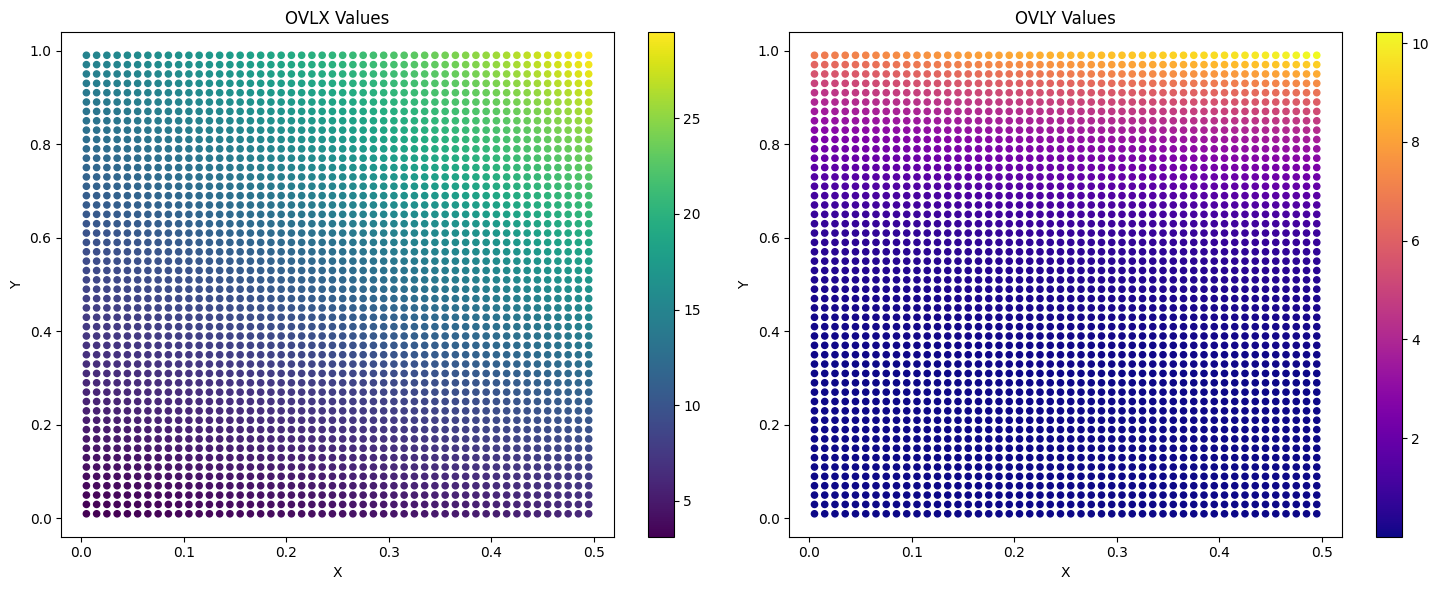

In [5]:
plot_results(grid_results, None)

In [6]:
def plot_results(df, save_path=None):
    """
    可视化结果 - 分别绘制ovlx和ovly的热力图
    
    Args:
        df: 包含x, y, ovlx, ovly的DataFrame
        save_path: 保存图片的路径（可选）
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.colors import Normalize
        
        # 绘制OVLX
        plt.figure(figsize=(10, 8))
        scatter1 = plt.scatter(df['x'], df['y'], c=df['ovlx'], cmap='viridis', s=30, alpha=0.8)
        plt.xlabel('X', fontsize=12)
        plt.ylabel('Y', fontsize=12)
        plt.title('OVLX Values Heat Map', fontsize=14, fontweight='bold')
        plt.colorbar(scatter1, label='OVLX Value')
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(f"{save_path}_ovlx.png", dpi=300, bbox_inches='tight')
            print(f"OVLX图片已保存到: {save_path}_ovlx.png")
        
        plt.show()
        
        # 绘制OVLY  
        plt.figure(figsize=(10, 8))
        scatter2 = plt.scatter(df['x'], df['y'], c=df['ovly'], cmap='plasma', s=30, alpha=0.8)
        plt.xlabel('X', fontsize=12)
        plt.ylabel('Y', fontsize=12)
        plt.title('OVLY Values Heat Map', fontsize=14, fontweight='bold')
        plt.colorbar(scatter2, label='OVLY Value')
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(f"{save_path}_ovly.png", dpi=300, bbox_inches='tight')
            print(f"OVLY图片已保存到: {save_path}_ovly.png")
        
        plt.show()
        
        # 显示数值统计信息
        print(f"\nOVLX统计信息:")
        print(f"  最小值: {df['ovlx'].min():.6f}")
        print(f"  最大值: {df['ovlx'].max():.6f}")
        print(f"  平均值: {df['ovlx'].mean():.6f}")
        print(f"  标准差: {df['ovlx'].std():.6f}")
        
        print(f"\nOVLY统计信息:")
        print(f"  最小值: {df['ovly'].min():.6f}")
        print(f"  最大值: {df['ovly'].max():.6f}")
        print(f"  平均值: {df['ovly'].mean():.6f}")
        print(f"  标准差: {df['ovly'].std():.6f}")
        
    except ImportError:
        print("matplotlib未安装，跳过可视化")

# 另外，如果你想要真正的热力图（而不是散点图），可以使用这个函数：
def plot_heatmap(df, save_path=None):
    """
    绘制真正的热力图
    """
    try:
        import matplotlib.pyplot as plt
        import numpy as np
        
        # 重新整理数据为网格形式
        x_unique = sorted(df['x'].unique())
        y_unique = sorted(df['y'].unique())
        
        # 创建网格
        ovlx_grid = np.zeros((len(y_unique), len(x_unique)))
        ovly_grid = np.zeros((len(y_unique), len(x_unique)))
        
        for i, y_val in enumerate(y_unique):
            for j, x_val in enumerate(x_unique):
                mask = (df['x'] == x_val) & (df['y'] == y_val)
                if mask.any():
                    ovlx_grid[i, j] = df.loc[mask, 'ovlx'].iloc[0]
                    ovly_grid[i, j] = df.loc[mask, 'ovly'].iloc[0]
        
        # 绘制OVLX热力图
        plt.figure(figsize=(12, 8))
        plt.imshow(ovlx_grid, cmap='viridis', aspect='auto', origin='lower',
                   extent=[min(x_unique), max(x_unique), min(y_unique), max(y_unique)])
        plt.colorbar(label='OVLX Value')
        plt.xlabel('X', fontsize=12)
        plt.ylabel('Y', fontsize=12)
        plt.title('OVLX Heat Map', fontsize=14, fontweight='bold')
        
        if save_path:
            plt.savefig(f"{save_path}_ovlx_heatmap.png", dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # 绘制OVLY热力图
        plt.figure(figsize=(12, 8))
        plt.imshow(ovly_grid, cmap='plasma', aspect='auto', origin='lower',
                   extent=[min(x_unique), max(x_unique), min(y_unique), max(y_unique)])
        plt.colorbar(label='OVLY Value')
        plt.xlabel('X', fontsize=12)
        plt.ylabel('Y', fontsize=12)
        plt.title('OVLY Heat Map', fontsize=14, fontweight='bold')
        
        if save_path:
            plt.savefig(f"{save_path}_ovly_heatmap.png", dpi=300, bbox_inches='tight')
        
        plt.show()
        
    except ImportError:
        print("matplotlib未安装，跳过可视化")

OVLX图片已保存到: results_ovlx.png


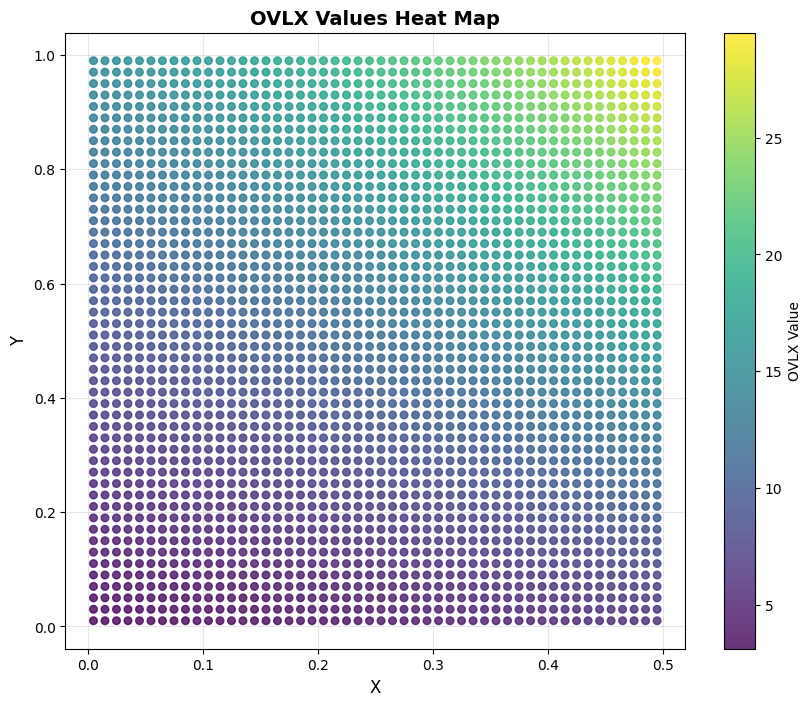

OVLY图片已保存到: results_ovly.png


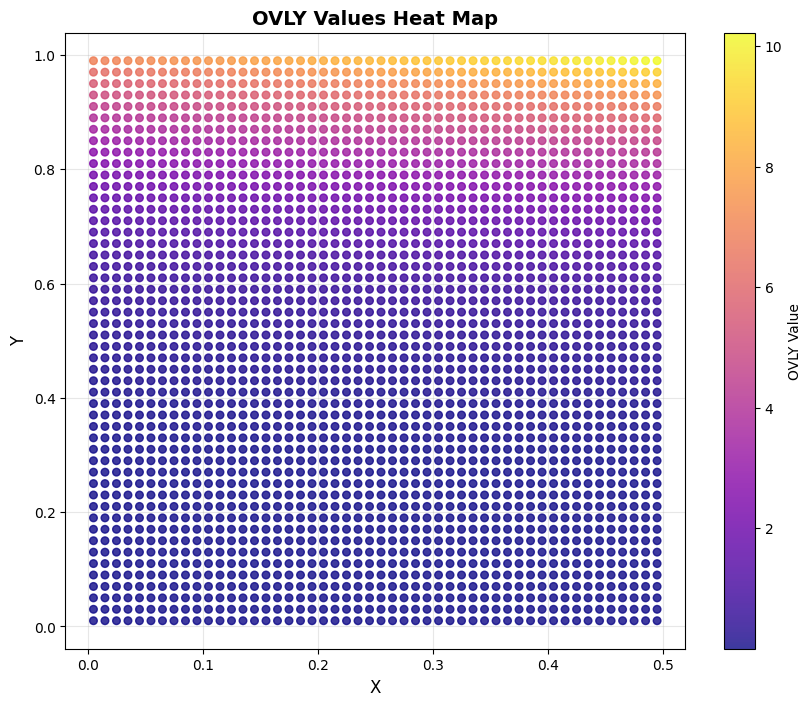


OVLX统计信息:
  最小值: 3.115856
  最大值: 29.498240
  平均值: 12.277539
  标准差: 5.613263

OVLY统计信息:
  最小值: 0.000000
  最大值: 10.219655
  平均值: 1.484939
  标准差: 2.258456


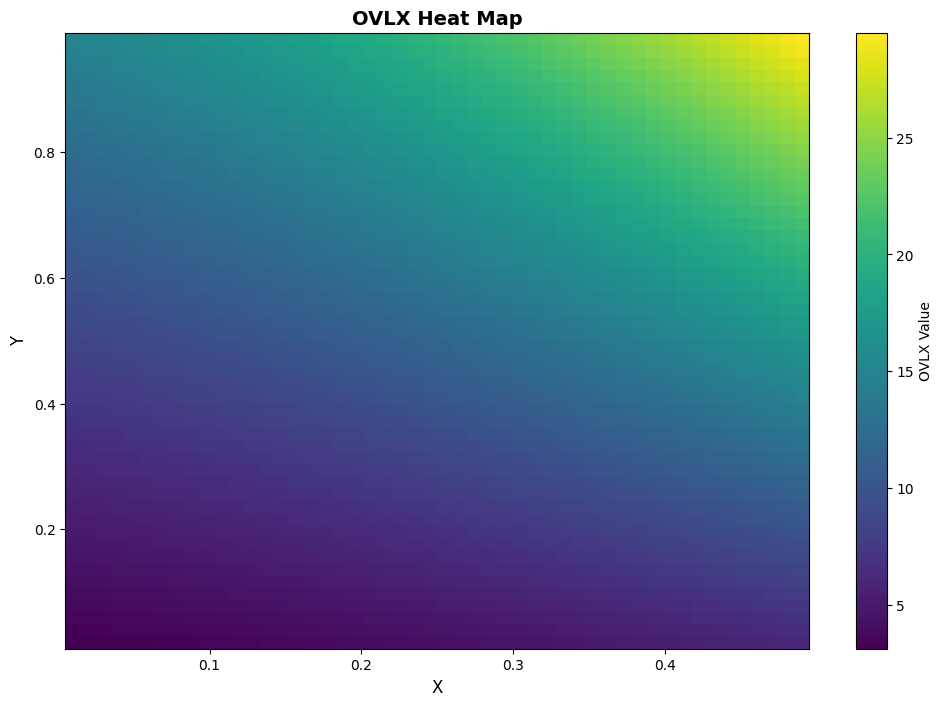

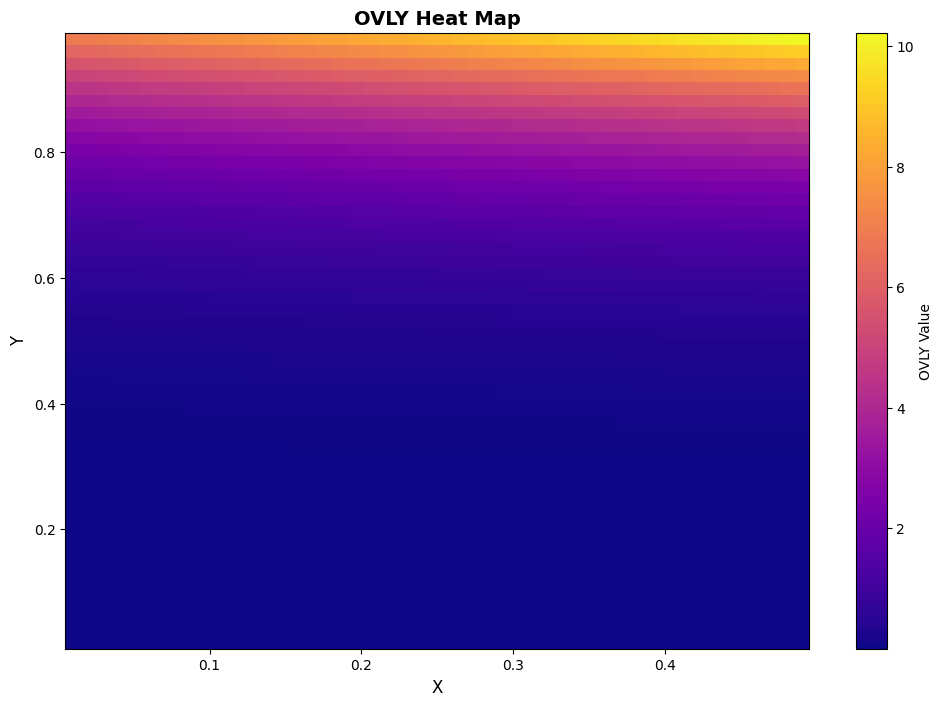

In [7]:
# 散点图形式的热力图（分别显示）
plot_results(grid_results, "results")

# 或者使用真正的热力图
plot_heatmap(grid_results, "heatmap")